In [ ]:
import torch
from torch_geometric.data import Data
from itertools import combinations
import numpy as np

train_ingr_id = './utils/data/train_labels_ingr_id.csv'
val_ingr_id = './utils/data/val_labels_ingr_id.csv'
test_ingr_id = '../utils/data/test_labels_ingr_id.csv'
import pandas as pd

train_df = pd.read_csv(train_ingr_id)
val_df = pd.read_csv(val_ingr_id)
# test_df = pd.read_csv(test_ingr_id)
train_df = pd.concat([train_df, val_df], ignore_index=True)
# val_df = pd.read_csv(val_ingr_id)
# test_df = pd.read_csv(test_ingr_id)

# combine the train, validation, and test DataFrames
# df = pd.concat([train_df, val_df, test_df], ignore_index=True)
df = train_df
print(len(df))

num_ingredients = len(df.columns) - 2  # Subtract 2 for 'dish_id' and 'image_path' columns

# df structure
# dish_id, ingredient 1, ingredient 2, ingredient 3, ingredient 4, ingredient 5, ingredient 6, ingredient 7, ingredient 8, ingredient 9, ingredient 10, ...
# x, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0
ingr_list = []
# for each dish, add the index of the ingredients where the value is 1 to the list
# e.g. dish_1 = [1, 3], dish_2 = [1, 4], dish_3 = [2, 3], ...
# ingr_list = [[1, 3], [1, 4], [2, 3], ...]
# Iterate over each row of the DataFrame
for _, row in df.iterrows():
    # We assume that the first column is 'dish_id' and the remaining columns represent ingredients.
    # Extract the values starting from the second column onward (i.e., ingredient columns)
    # last column is the image_path, so we exclude it
    ingredient_values = row.iloc[1:-1]
    
    # Find the indices (0-based) of the ingredients where the value is 1
    selected_indices = [i for i, val in enumerate(ingredient_values) if val == 1]
    
    # Append the list of selected ingredient indices for this dish
    ingr_list.append(selected_indices)

print(df.iloc[0])
# print the second row of the DataFrame
print(ingr_list[0])

2958
id                       dish_1562699612
brown rice                           1.0
quinoa                               1.0
olive oil                            1.0
carrot                               0.0
                            ...         
chilaquiles                          0.0
pasta salad                          0.0
balsamic vinegar                     0.0
toast                                0.0
img_indx            dish_1562699612.jpeg
Name: 0, Length: 201, dtype: object
[0, 1, 2]


In [174]:
import numpy as np
adj_matrix = np.zeros((num_ingredients, num_ingredients), dtype=np.int32)

for dish in ingr_list:
    for i, j in combinations(dish, 2):
        adj_matrix[i, j] += 1
        adj_matrix[j, i] += 1

adj_matrix        


array([[  0,  12, 201, ...,   0,   0,   0],
       [ 12,   0, 124, ...,   0,   0,   0],
       [201, 124,   0, ...,   1,   1,   0],
       ...,
       [  0,   0,   1, ...,   0,   0,   0],
       [  0,   0,   1, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

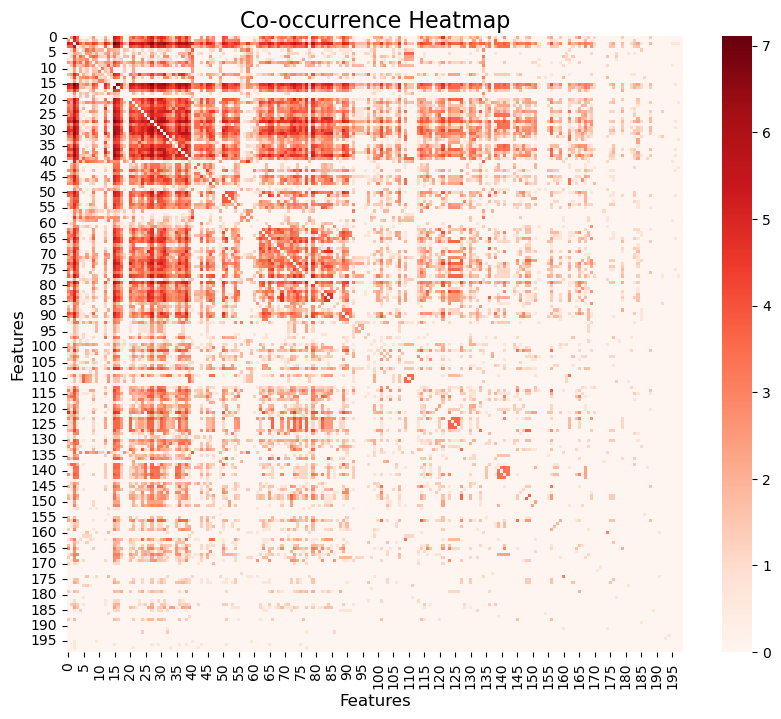

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# log-transform the adjacency matrix to reduce the effect of outliers
normalized_adj_matrix = np.log1p(adj_matrix)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_adj_matrix, cmap="Reds", annot=False, square=True)

# Add labels and title
plt.title("Co-occurrence Heatmap", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Display the plot
plt.show()


In [176]:
if np.allclose(adj_matrix, adj_matrix.T):
    print("The graph is undirected.")
else:
    print("The graph is directed.")


The graph is undirected.


In [177]:
raw_edge_index = torch.tensor(np.where(adj_matrix >= 1), dtype=torch.long)
print(f"raw_edge_index: {raw_edge_index.shape}")
raw_edge_weight = torch.tensor(adj_matrix[raw_edge_index[0], raw_edge_index[1]], dtype=torch.float)
print(f"raw_edge_weight: {raw_edge_weight.shape}")

print(f"Max edge weight: {raw_edge_weight.max()}")
print(f"Min edge weight: {raw_edge_weight.min()}")
print(f"Mean edge weight: {raw_edge_weight.mean()}")
print(f"Median edge weight: {raw_edge_weight.median()}")
print(f"Std edge weight: {raw_edge_weight.std()}")

raw_edge_index: torch.Size([2, 13082])
raw_edge_weight: torch.Size([13082])
Max edge weight: 1225.0
Min edge weight: 1.0
Mean edge weight: 21.395505905151367
Median edge weight: 6.0
Std edge weight: 49.13983917236328


In [178]:
threshold = 7

# set random seed for reproducibility
np.random.seed(125)

# convert adjacency matrix to PyTorch Geometric graph
edge_index = torch.tensor(np.where(adj_matrix >= threshold), dtype=torch.long)
print(edge_index.size())
edge_index

# print out the nodes that are disconnected
disconnected_nodes = set(range(num_ingredients)) - set(edge_index.flatten().numpy())
all_nodes = set(range(num_ingredients))
validate_nodes = all_nodes - disconnected_nodes

print(f"Disconnected nodes: {disconnected_nodes}")

# Add weak edges for disconnected nodes
for node in disconnected_nodes:
    # Find valid neighbors (above threshold)

    neighbor = np.random.choice(list(validate_nodes))


    # Add bidirectional weak edges
    weak_edges = torch.tensor([[node, neighbor], [neighbor, node]], dtype=torch.long)
    edge_index = torch.cat([edge_index, weak_edges], dim=1)

print(f"Final edge_index size: {edge_index.size()}")

torch.Size([2, 6518])
Disconnected nodes: {129, 143, 19, 152, 153, 154, 157, 161, 163, 170, 171, 172, 173, 175, 177, 178, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 96, 98, 108, 112}
Final edge_index size: torch.Size([2, 6594])


In [179]:
edge_weight = torch.tensor(adj_matrix[edge_index[0], edge_index[1]], dtype=torch.float)
print(len(edge_weight))
edge_weight # edge_weight is the number of co-occurrences between the edge index

6594


tensor([ 12., 201.,  39.,  ...,   0.,   0.,   0.])

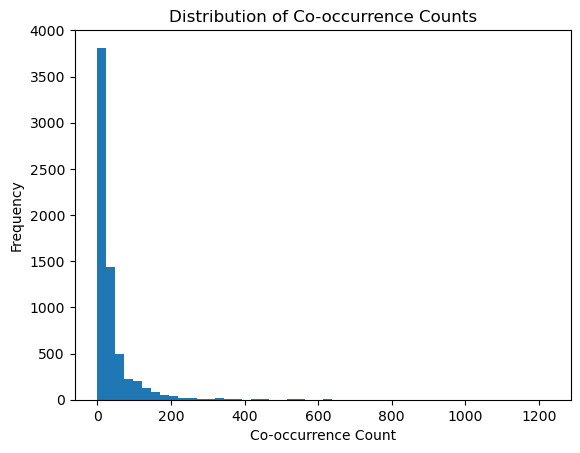

In [180]:
import matplotlib.pyplot as plt

plt.hist(edge_weight.numpy(), bins=50)
plt.title("Distribution of Co-occurrence Counts")
plt.xlabel("Co-occurrence Count")
plt.ylabel("Frequency")
plt.show()


In [181]:
max_weight = edge_weight.max()
min_weight = edge_weight.min()
avg_weight = edge_weight.mean()
# Assume edge_weight contains all co-occurrence counts
print(f"Max weight: {max_weight}, Min weight: {min_weight}, Average weight: {avg_weight}")

# log-transform the edge weights
edge_weight = edge_weight.log1p()
edge_weight


Max weight: 1225.0, Min weight: 0.0, Average weight: 39.62480926513672


tensor([2.5649, 5.3083, 3.6889,  ..., 0.0000, 0.0000, 0.0000])

In [182]:
# After Normalizing the edge weights
max_weight = edge_weight.max()
min_weight = edge_weight.min()
avg_weight = edge_weight.mean()
print(f"Max weight: {max_weight}, Min weight: {min_weight}, Average weight: {avg_weight}")

Max weight: 7.111512184143066, Min weight: 0.0, Average weight: 3.1774797439575195


In [183]:
# min-max normalization
edge_weight = (edge_weight - min_weight) / (max_weight - min_weight)
edge_weight

tensor([0.3607, 0.7464, 0.5187,  ..., 0.0000, 0.0000, 0.0000])

In [184]:
max_weight = edge_weight.max()
min_weight = edge_weight.min()
avg_weight = edge_weight.mean()
print(f"Max weight: {max_weight}, Min weight: {min_weight}, Average weight: {avg_weight}")

Max weight: 1.0, Min weight: 0.0, Average weight: 0.4468079209327698


In [185]:
# Create node features (optional: identity matrix for simple embeddings)
node_features = torch.eye(num_ingredients)

# # create node features using Bert embeddings
# import torch

# # Load the pre-trained BERT model
# bert_embed = torch.load('./ingredient_embeddings_bert.pt')
# bert_embed.shape

# # assign the BERT embeddings as node features
# node_features = bert_embed

# node_features

In [186]:
graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weight)
graph


Data(x=[199, 199], edge_index=[2, 6594], edge_attr=[6594])

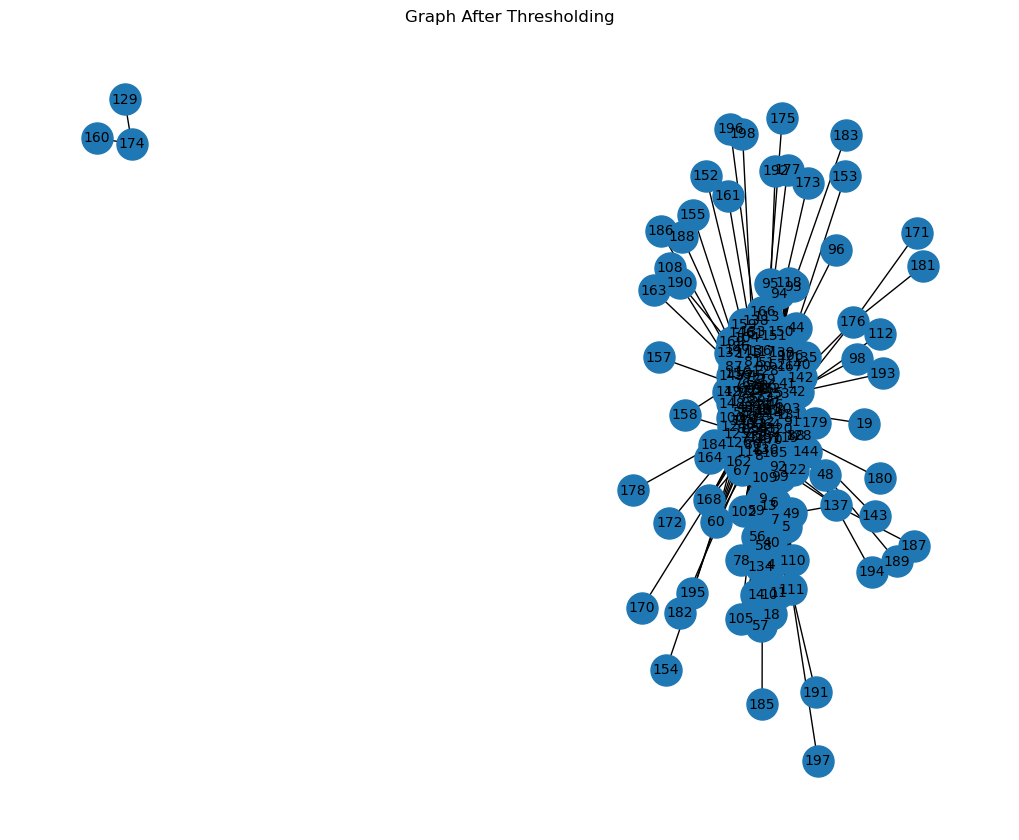

In [187]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

# Convert the graph to NetworkX format
graph_nx = to_networkx(graph, edge_attrs=["edge_attr"], to_undirected=True)

# Visualize the graph
plt.figure(figsize=(10, 8))
nx.draw(graph_nx, with_labels=True, node_size=500, font_size=10)
plt.title("Graph After Thresholding")
plt.show()


In [188]:
# save the graph
torch.save(graph, 'ingredient_graph_v3.pt')